# Desarrollo memoria

### Importaciones de librerías

In [22]:
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gc

# 
import datetime

# Tensorflow GPU config
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Keras libs
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, TimeDistributed, CuDNNGRU, GRU
import sklearn.metrics as metrics
from sklearn.preprocessing import RobustScaler

# Matplotlib setting
def set_chart_font():
    font = {'weight' : 'normal', 'size'   : 16}
    import matplotlib
    matplotlib.rc('font', **font)

# Jupyter stuff
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 13pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

## Cargando el df

In [2]:
# Se importa el dataset
df = pd.read_csv("./datasets/mediciones-netatmo-renam.csv") 

In [3]:
display(df.head(5))
print(df.shape)
print("Mostrando los nulos")
display(df.isnull().sum())

id  user_id  dispositivo_id  sector  temperatura  humedad     co2  \
0  523815    127.0             2.0       0         16.5     77.0  1080.0   
1  523816    127.0             2.0       0         16.4     77.0  1074.0   
2  523817    113.0             3.0       0         15.7     73.0   891.0   
3  523818    113.0             3.0       0         15.6     73.0   894.0   
4  523819    109.0             4.0       0         21.0     75.0  3991.0   

   ruido  measured_at    local_measured_at  js_measured_at  created_at  \
0   37.0   1494644400  2017-05-13 00:00:00   1494644400000  1494648008   
1   37.0   1494646200  2017-05-13 00:30:00   1494646200000  1494648008   
2   38.0   1494644400  2017-05-13 00:00:00   1494644400000  1494648012   
3   37.0   1494646200  2017-05-13 00:30:00   1494646200000  1494648012   
4   59.0   1494644400  2017-05-13 00:00:00   1494644400000  1494648016   

   updated_at  vivienda_id  
0  1494648008            6  
1  1494648008            6  
2  1494648012            9  
3  1494648012            9  
4  1494648016           11

(10169108, 14)
Mostrando los nulos


id                         0
user_id               299473
dispositivo_id        156446
sector                     0
temperatura              210
humedad                  210
co2                  4726543
ruido                4725843
measured_at                0
local_measured_at          0
js_measured_at             0
created_at                 0
updated_at                 0
vivienda_id                0
dtype: int64

Al ver el dataset se aprecia que hay 10169108 registros con 14 columnas cada uno. Resulta que la caracteristica sector indica 0 si es que la medicion es dentro de la casa o 1 si es que es fuera de ésta, para usos de esta memoria se determina que las mediciones dentro de la casa y fuera de esta deben de vivir en el mismo registro por lo que se carga el csv en una base de datos (postgres, ver anexo)  y se decide realizar dicha unificación, así es como se obtiene el nuevo dataset *'mediciones_unificadas.csv'*

In [2]:
try:
    del df
except:
    print("No hay df definido :(")
gc.collect()

df = pd.read_csv("./datasets/mediciones_unificadas.csv") 
# df.date_measured_at = pd.to_datetime(df.measured_at, unit='s')
df.date_measured_at = pd.to_datetime(df.date_measured_at)
df = df.drop(columns=['co2', 'ruido', 'dispositivo_id', 'measured_at'])

No hay df definido :(


In [5]:
display(df.head(5))
print("INFO DE LOS DATOS")
display(df.describe())
print("CANTIDAD DE NULOS POR ATRIBUTO")
display(df.isnull().sum())
print(df.shape)
print("Viviendas distintas:",len(df.vivienda_id.unique()))

id  vivienda_id  temperatura_interior  humedad_interior  \
0   1            3                  26.3                48   
1   2            3                  25.2                47   
2   3            3                  23.9                45   
3   4            3                  23.3                46   
4   5            3                  24.0                46   

   temperatura_exterior  humedad_exterior    date_measured_at  
0                  27.5                35 2015-11-26 20:30:00  
1                  25.4                35 2015-11-26 21:00:00  
2                  23.4                38 2015-11-26 21:30:00  
3                  22.4                38 2015-11-26 22:00:00  
4                  21.5                39 2015-11-26 22:30:00

INFO DE LOS DATOS


id   vivienda_id  temperatura_interior  humedad_interior  \
count  4.731498e+06  4.731498e+06          4.731498e+06      4.731498e+06   
mean   2.365750e+06  1.468023e+02          1.983571e+01      5.841729e+01   
std    1.365866e+06  8.426349e+01          4.103601e+00      1.130619e+01   
min    1.000000e+00  2.000000e+00          2.300000e+00      8.000000e+00   
25%    1.182875e+06  7.600000e+01          1.700000e+01      5.100000e+01   
50%    2.365750e+06  1.420000e+02          1.980000e+01      5.900000e+01   
75%    3.548624e+06  2.140000e+02          2.280000e+01      6.600000e+01   
max    4.731498e+06  3.070000e+02          5.800000e+01      1.000000e+02   

       temperatura_exterior  humedad_exterior  
count          4.731498e+06      4.731498e+06  
mean           1.660592e+01      6.643283e+01  
std            6.370523e+00      1.518488e+01  
min           -1.580000e+01      1.300000e+01  
25%            1.220000e+01      5.600000e+01  
50%            1.610000e+01      6.800000e+01  
75%            2.060000e+01      7.800000e+01  
max            5.480000e+01      1.000000e+02

CANTIDAD DE NULOS POR ATRIBUTO


id                      0
vivienda_id             0
temperatura_interior    0
humedad_interior        0
temperatura_exterior    0
humedad_exterior        0
date_measured_at        0
dtype: int64

(4731498, 7)
Viviendas distintas: 303


Ahora al ver el nuevo dataset unificado se aprecia que hay 4731498 registros, estos de un total de 303 viviendas distintas.

Se va a proceder a sacar una muestra del orden del 3% de los datos para poder graficar las variables

In [6]:
df_sample = df.sample(frac=0.03, replace=False, random_state=23)

Se crea una carácteristica que determina la época del año donde ocurre la medición. Esto con el objetivo de diferenciar en el gráfico

In [7]:
def temporada(a):
    fecha = pd.to_datetime(a)
    year = fecha.year
    otoño = (datetime.datetime(year, 3, 20), datetime.datetime(year, 6, 21))
    invierno = (datetime.datetime(year, 6, 21), datetime.datetime(year, 9, 23))
    primavera = (datetime.datetime(year, 9, 23), datetime.datetime(year, 12, 21))
    
    if otoño[0] <= fecha < otoño[1]:
        return "otoño"
    elif invierno[0] <= fecha < invierno[1]:
        return "invierno"
    elif primavera[0] <= fecha < primavera[1]:
        return "primavera"
    else:
        return "verano"
    
df_sample['epoca'] = np.vectorize(temporada)(df_sample['date_measured_at'])

In [8]:
print("Mostrando la forma de la muestra")
print(df_sample.shape)

Mostrando la forma de la muestra
(141945, 8)


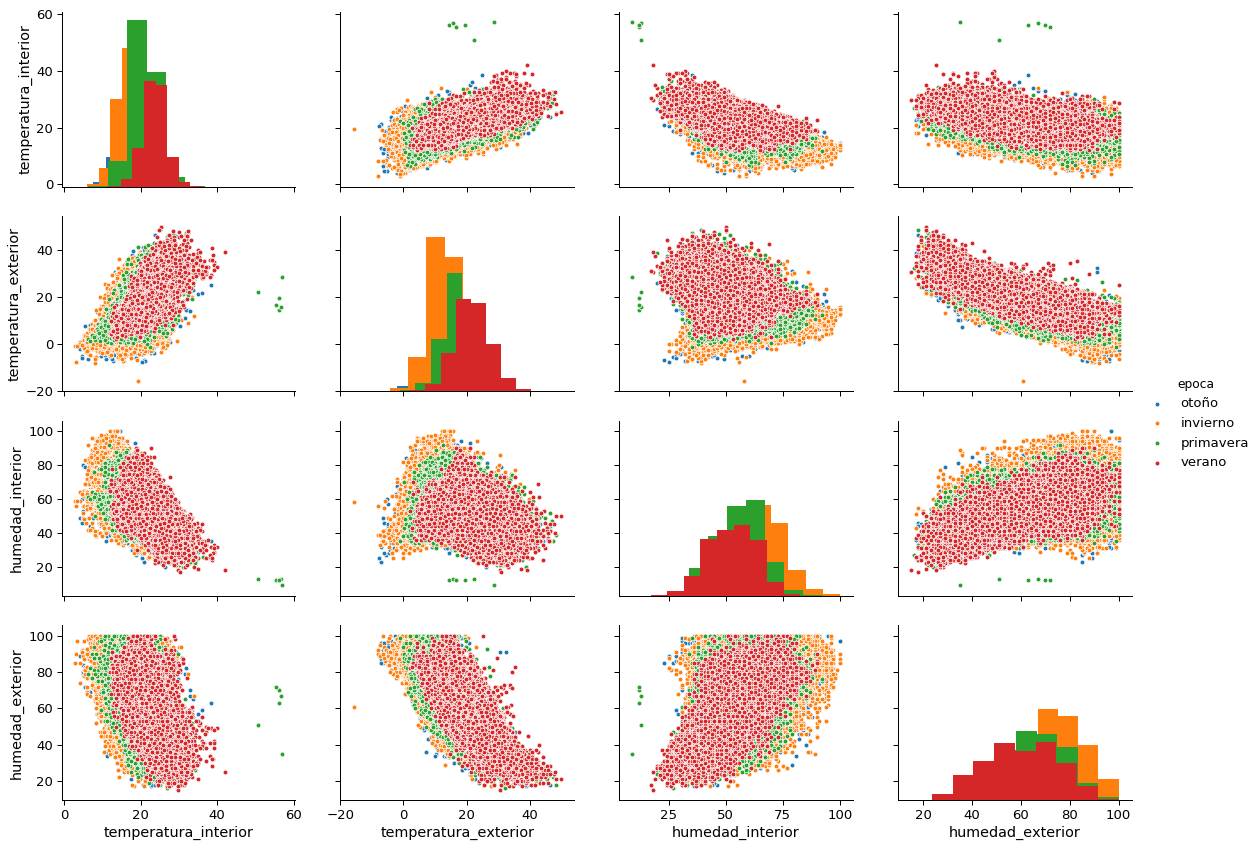

In [11]:
# VARIABLES = ['temperatura_interior', 'temperatura_exterior', 'humedad_interior', 'humedad_exterior', 'co2', 'ruido']
VARIABLES = ['temperatura_interior', 'temperatura_exterior', 'humedad_interior', 'humedad_exterior']
sns.set_context("paper", font_scale=1.5) 
sns.pairplot(df_sample, vars=VARIABLES, height=3, dropna=True, hue="epoca", diag_kind="hist", aspect=4/3)

Al ver el gráfico del cruce de todas las variables se aprecia lo siguiente
- **Temperatura interior:** Se relaciona con la temperatura exterior y la humedad interior
- **Temperatura exterior:** Se relaciona con humedad exterior y temperatura interior
- **Humedad interior:** Se relaciona con temperatura interior
- **Humedad exterior:** Se relaciona con temperatura exterior

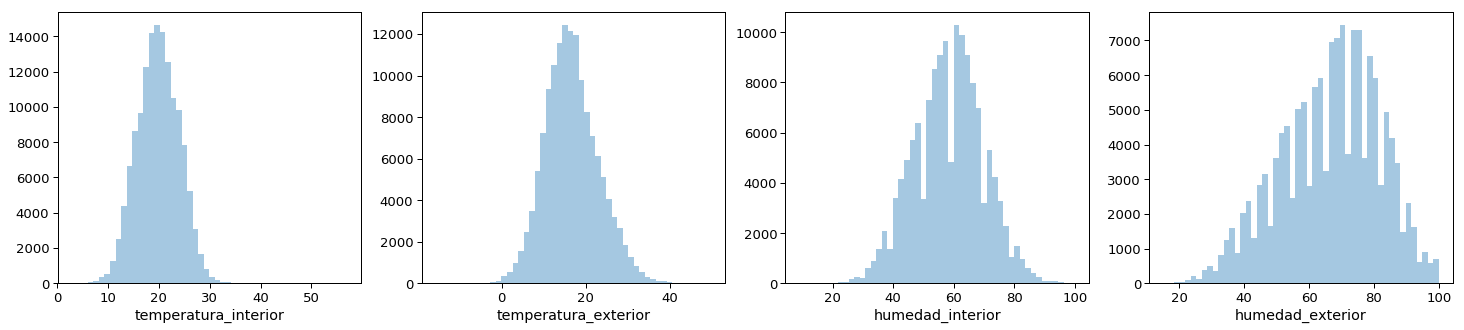

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

for i in range(len(VARIABLES)):
    sns.distplot(df_sample[VARIABLES[i]].dropna(), hist=True, kde=False, ax=ax[i])
    
plt.show()

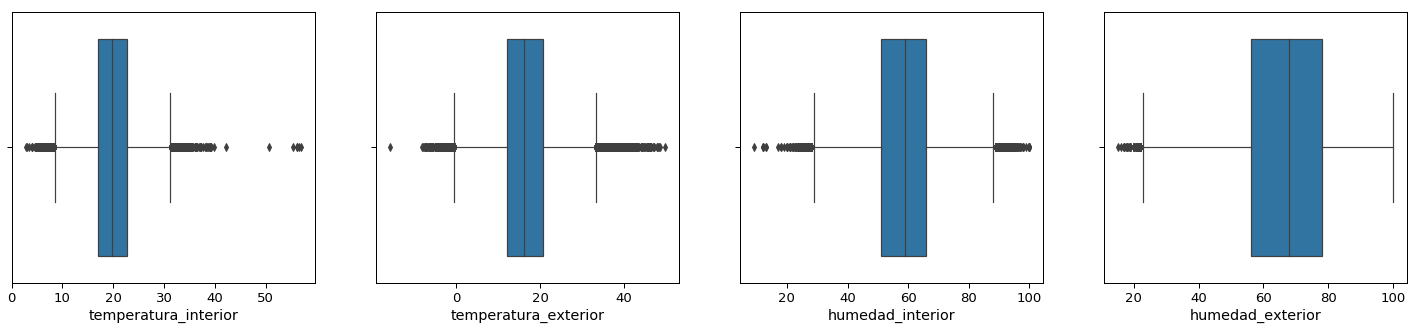

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(25,5))

for i in range(len(VARIABLES)):
    sns.boxplot(x=df_sample[VARIABLES[i]].dropna(), ax=ax[i], orient="h")

## Deteccción de outliers multi-variado

IGNORAR ESTA SECCIÓN 
https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/

In [ ]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
display(df_sample.head())
print(df_sample.shape)

In [ ]:
# Se trasnforma la data para que quede toda junta
x1 = df_sample['temperatura_interior'].values.reshape(-1,1)
x2 = df_sample['humedad_interior'].values.reshape(-1,1)
x3 = df_sample['temperatura_exterior'].values.reshape(-1,1)
x4 = df_sample['humedad_exterior'].values.reshape(-1,1)

X = np.concatenate((x1,x2, x3, x4),axis=1)

In [ ]:
def getOutliers(model, X):
    # Anormality score
    # scores_pred = model.decision_function(X) * -1
    y_pred = model.predict(X)
    
    # Muestra por pantalla el número de outliers
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    print('OUTLIERS : ', n_outliers,'INLIERS : ',n_inliers)
    return y_pred

In [ ]:
# Porcentage de outliers en la muestra
OUTLIERS_FRACTION = 0.05

model = IForest(contamination=OUTLIERS_FRACTION, random_state= 22, behaviour='new')
model.fit(X)

outlierIndex = getOutliers(model, X)

## Análisis del estado de la series de tiempo

Por cada una de las casas se tiene una serie de tiempo distinta, entonces se procede a separar cada una de las series en su respectivo dataframe

In [3]:
HASH_OF_TIME_SERIES = {}

TARGET_DF = df

# display(TARGET_DF.head())

for i, g in TARGET_DF.groupby('vivienda_id'):
    HASH_OF_TIME_SERIES[i] = g.set_index('date_measured_at')
    
# display(HASH_OF_TIME_SERIES[2].head())

def show_stats(seried_df):
    print("Número de registros:", seried_df.shape[0])
    temp = seried_df.resample('30min').mean()
    missing_rate = (temp.isna().sum()/len(temp) * 100).temperatura_interior
    print("Porcentaje de información faltante:", missing_rate)

Ahora para ver el estado de las casas se procede a calcular el porcentaje de información faltante para cada una de las series.

In [4]:
houses_stats = []
training_houses_pool = []
for i in HASH_OF_TIME_SERIES.keys():
    temp = HASH_OF_TIME_SERIES[i].resample('30min').mean()
    missing_rate = (temp.isna().sum()/len(temp) * 100).temperatura_interior
    
    # Que le falte 10% o menos y que tenga 6 meses de medición
    if missing_rate <= 10 and HASH_OF_TIME_SERIES[i].shape[0] > 8000:
        training_houses_pool.append(i)
        # print("Casa {}, Porcentage de null: {}%".format(i, missing_rate))
        houses_stats.append( (i, HASH_OF_TIME_SERIES[i].shape[0], missing_rate) )
        
print("Cantidad de casas con las que entrenar:", len(training_houses_pool))
print("Total casas:", len(HASH_OF_TIME_SERIES.keys()))

print("5 Casas con más datos")
print(sorted(houses_stats, key=lambda x: x[1], reverse=True)[:5])

Cantidad de casas con las que entrenar: 89
Total casas: 303
5 Casas con más datos
[(38, 37052, 6.184574050135605), (45, 36409, 3.795794207115461), (68, 33107, 5.869125893035038), (67, 33055, 6.028520194688754), (135, 32815, 0.06707726080858589)]


Del total de 303 casas se aprecia que tan sólo 112 casas tienen 10% o menos de información faltante y dentro de estas destaca la casa 135 por tener 32815 registros disponibles.

In [ ]:
display(HASH_OF_TIME_SERIES[2].resample('30min').mean().head())

In [ ]:
import math

HOUSE_IN_STUDY = 2#16

temp = HASH_OF_TIME_SERIES[HOUSE_IN_STUDY].resample('30min').mean()
lakes = []
lake=[]
in_lake = False

inicio = True
fechas = []

for index, row in temp.iterrows():
    
    temperatura = getattr(row, 'temperatura_interior')
    fecha = index
    
    if inicio:
        fechas.append(fecha)
        inicio = False
    
    # Caso en que se inicia una laguna
    if math.isnan(temperatura) and not in_lake:
        in_lake = True
        lake.append(fecha)
        
    # Caso termina laguna
    elif in_lake and not math.isnan(temperatura):
        in_lake = False
        lake.append(fecha)
        lakes.append(lake)
        lake = list()
        
fechas.append(index)

In [ ]:
print(fechas)
for x, y in lakes:
    print(y-x)
    
if len(lakes) == 0:
    print("Está llena al 100%")

In [ ]:
HASH_OF_TIME_SERIES.keys()

## Transformación de los datos

Las series de tiempo actualmente están cargadas en dataframes de pandas (1 por cada casa), ahora lo que se va a hacer es hacer un tratamiento preliminar de los datos el cual consiste en escalarlos para que todos queden en la misma escala (ya que la temperatura y humedad están en escalas distintas), además en este tratamiento de los datos se va a ocupar un escalador robusto a outliers ya que como se vió en los boxplot anteriormente se aprecia que hay outliers en las 4 variables en estudio

In [18]:
display(HASH_OF_TIME_SERIES[2].head(3))
se print(HASH_OF_TIME_SERIES[2].shape)

id  vivienda_id  temperatura_interior  \
date_measured_at                                               
2016-01-01 03:00:00  3084            2                  25.0   
2016-01-01 03:30:00  3089            2                  24.9   
2016-01-01 04:00:00  3094            2                  24.8   

                     humedad_interior  temperatura_exterior  humedad_exterior  
date_measured_at                                                               
2016-01-01 03:00:00                46                  21.5                48  
2016-01-01 03:30:00                45                  21.5                47  
2016-01-01 04:00:00                45                  21.7                46

(42642, 6)


Se crean funciones para realizar la estandarización con el RobustScaler proveído por la librería sklearn

In [4]:
from sklearn.preprocessing import RobustScaler

FEATURES_IN_STUDY = ["temperatura_interior", "humedad_interior", "temperatura_exterior", "humedad_exterior"]
# TRAIN_LENGTH = int(HASH_OF_TIME_SERIES[2].shape[0] * 0.8)

def standarize_train(serie_df):
    scalers_dictionary = dict()
    
    # Se pone un RobustScaler por cada feature
    for i in FEATURES_IN_STUDY:
        scalers_dictionary[i] = RobustScaler()
    
    copy = serie_df.copy()
    
    for column_name in FEATURES_IN_STUDY:
        # Se le hace fit al scaler
        scalers_dictionary[column_name].fit( np.expand_dims(copy[column_name], axis=1))

        # Se transforma la data
        copy[column_name] = scalers_dictionary[column_name].transform( np.expand_dims(copy[column_name], axis=1) )

    return (copy, scalers_dictionary)

def standarize_val(serie_df, scalers_dictionary):
    copy = serie_df.copy()
    for column_name in FEATURES_IN_STUDY:
        # Se transforma la data
        copy[column_name] = scalers_dictionary[column_name].transform(np.expand_dims(copy[column_name], axis=1))
        
    return copy

También se crea una función para aplicar *lag* a la serie de tiempo. Esto se refiere a que en un ejemplo a utilizar en la red neuronal se tendrá la medición de lo que se ve actualmente y lo que ha ocurrido en el pasado según el lag aplicado. En este caso lo que se va a hacer es ver las 2 mediciones anteriores junto a la actual.

In [5]:
def generate_lag(serie_df, lag):
    X = list()
    Y = list()
    last_seen = list()
    
    for index, row in serie_df.iterrows():
        
        current_record = list()
        
        for i in FEATURES_IN_STUDY:
            current_record.append(row[i])
        
        # current_record = [row['temperatura_interior'], row['humedad_interior'], row['temperatura_exterior'], row['humedad_exterior']]
        
        # print(current_record)
        
        if len(last_seen) < lag:
            last_seen.append(current_record)
            
        else:
            # print("Mostrando current_record:", current_record)
            
            # print("Mostrando last_seen:",last_seen)
            Y.append(list(current_record))
            X.append(list(last_seen))
            
            # print("Mostrando x", X)
            # print("Mostrando y", Y)
            
            del last_seen[0]
            last_seen.append(current_record)
            
    return np.asarray(X),np.asarray(Y)

Finalmente se crean 2 funciones de alto nivel que dada la serie de tiempo entregan la matrices (entrenamiento, validación) de pares ejemplo-solución.

In [6]:
TRAIN_PERCENTAGE = 0.8

def generate_matrix(serie_df, amount_of_lag):
    TRAIN_LENGTH = int(serie_df.shape[0] * TRAIN_PERCENTAGE)
    
    train_df , scalers_dictionary = standarize_train( serie_df[0:TRAIN_LENGTH] )
    val_df = standarize_val( serie_df[TRAIN_LENGTH:], scalers_dictionary )

    X_train, Y_train = generate_lag(train_df, amount_of_lag)  
    X_val, Y_val = generate_lag(val_df, amount_of_lag)
    
    return ( (X_train, Y_train), (X_val, Y_val), scalers_dictionary )

def generate_matrix_from_scalers(serie_df, scalers, amount_of_lag):
    TRAIN_LENGTH = int(serie_df.shape[0] * TRAIN_PERCENTAGE)
    
    train_df = standarize_val( serie_df[:TRAIN_LENGTH], scalers )
    val_df = standarize_val( serie_df[TRAIN_LENGTH:], scalers )

    AMOUNT_OF_LAG = 3
    
    X_train, Y_train = generate_lag(train_df, amount_of_lag)  
    X_val, Y_val = generate_lag(val_df, amount_of_lag)
    
    return ( (X_train, Y_train), (X_val, Y_val) )

## Entrenando la primera red neuronal

Se decide utilizar una red neuronal recurrente para el problema debido a que se tienen mediciones del pasado (2 instances anteriores) y la actual. Para entrenar la red se utilizar la casa número 2

In [53]:
show_stats(HASH_OF_TIME_SERIES[135])

Número de registros: 32815
Porcentaje de información faltante: 0.06707726080858589


In [12]:
HOUSE_TO_TRAIN = 135
EXAMPLE_AMOUNT_OF_LAG = 3

train_data, valitation_data, scalers = generate_matrix(HASH_OF_TIME_SERIES[HOUSE_TO_TRAIN], EXAMPLE_AMOUNT_OF_LAG)
print(train_data[0].shape)
print(valitation_data[0].shape)

(26249, 3, 4)
(6560, 3, 4)


In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, TimeDistributed, CuDNNGRU, GRU

model = Sequential()

# Recurrente
model.add(CuDNNGRU(input_shape=(EXAMPLE_AMOUNT_OF_LAG, 4), units=100, return_sequences=False))

# FF
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(4))

model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['mean_absolute_percentage_error'])  
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, 100)               31800     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 61,756
Trainable params: 61,756
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(train_data[0], train_data[1], validation_data=(valitation_data[0], valitation_data[1]), epochs=15, batch_size=256, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 26249 samples, validate on 6560 samples
Epoch 1/15
26249/26249 [==============================] - 18s 670us/step - loss: 0.0614 - val_loss: 0.0150
Epoch 2/15
26249/26249 [==============================] - 0s 12us/step - loss: 0.0095 - val_loss: 0.0089
Epoch 3/15
26249/26249 [==============================] - 0s 12us/step - loss: 0.0070 - val_loss: 0.0081
Epoch 4/15
26249/26249 [==============================] - 0s 12us/step - loss: 0.0063 - val_loss: 0.0074
Epoch 5/15
26249/26249 [==============================] - 0s 12us/step - loss: 0.0059 - val_loss: 0.0069
Epoch 6/15
26249/26249 [==============================] - 0s 12us/step - loss: 0.0056 - val_loss: 0.0064
Epoch 7/15
26249/26249 [==============================] - 0s 12us/step - loss: 0.0055 - val_loss: 0.0064
Epoch 8/15
26249/26249 [==============================] - 0s 11us/step - loss: 0.0053 - val_loss: 0.0065
Epoch 9/15
26249/26249 [==============================] - 0s 

In [10]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

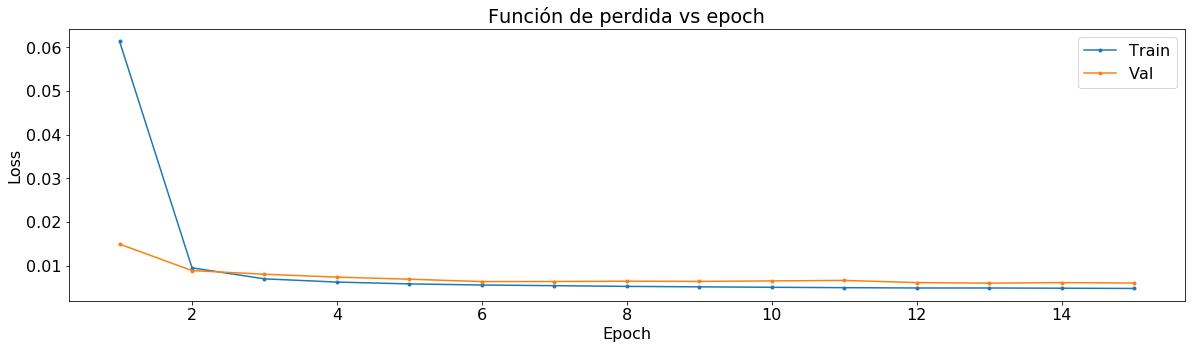

In [15]:
def chart_loss(history, epoch_number):
    set_chart_font()
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history['loss'], '.-')
    plt.plot(epoch_arr, history.history['val_loss'], '.-')
    # plt.plot(epoch_arr, history.history['val_mean_absolute_percentage_error'], '.-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend( ('Train', 'Val', 'MAE') )
    plt.title("Función de perdida vs epoch")

    # min_index = np.argmin(history.history['val_loss'])
    # min_value = history.history['val_mean_absolute_percentage_error'][min_index].round(3)
    # plt.annotate('Min = {}'.format(min_value), xy=(min_index+1, min_value), xycoords='data', xytext=(-100, 100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))


    plt.show()

chart_loss(history, 15)

In [17]:
y_pred = model.predict(valitation_data[0])

/home/francisco/anaconda3/envs/redesneuronales/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


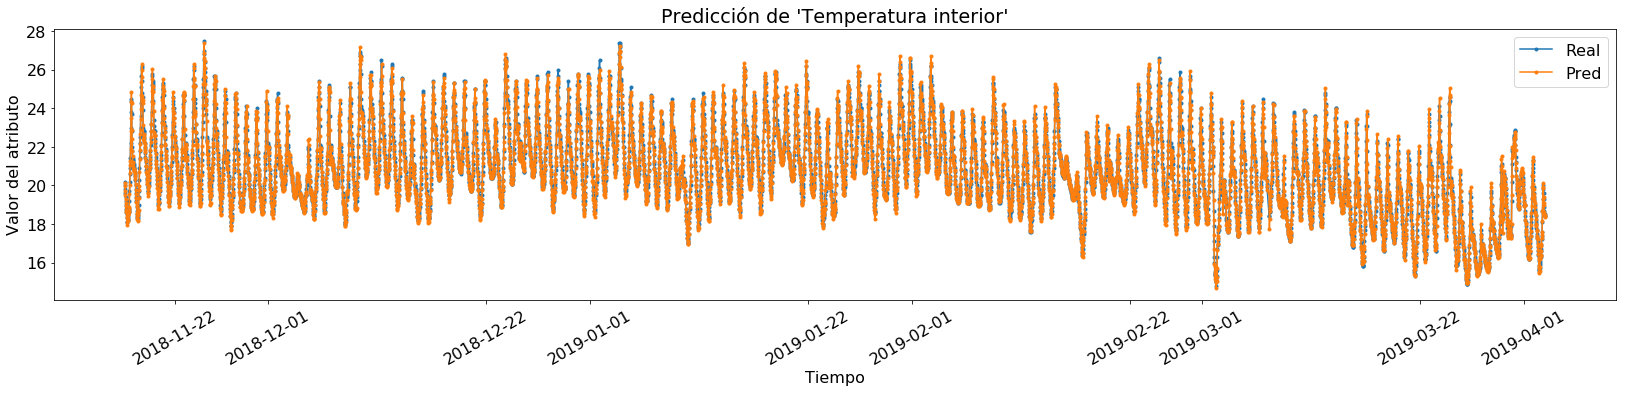

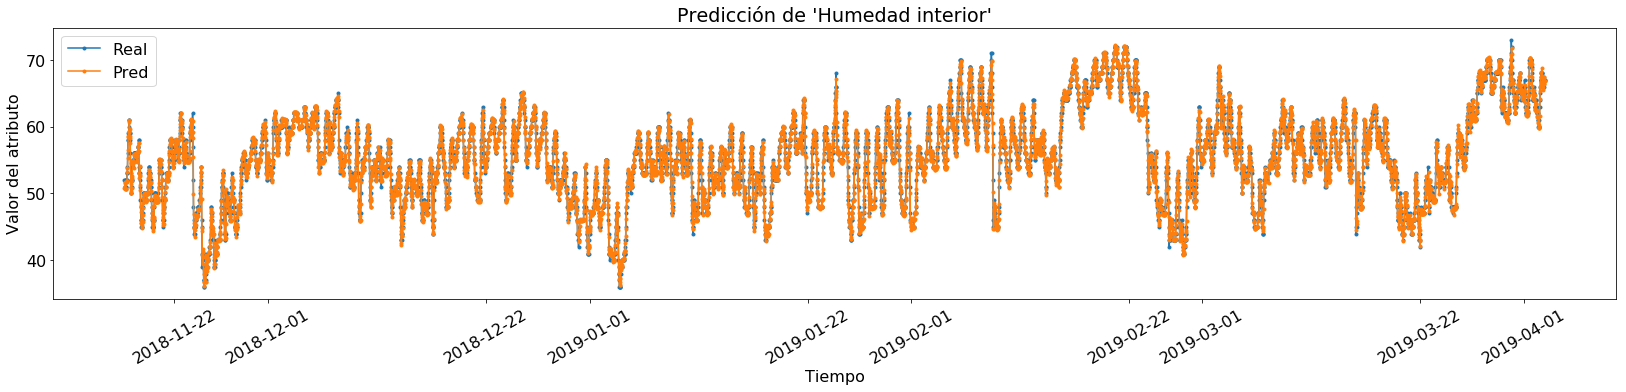

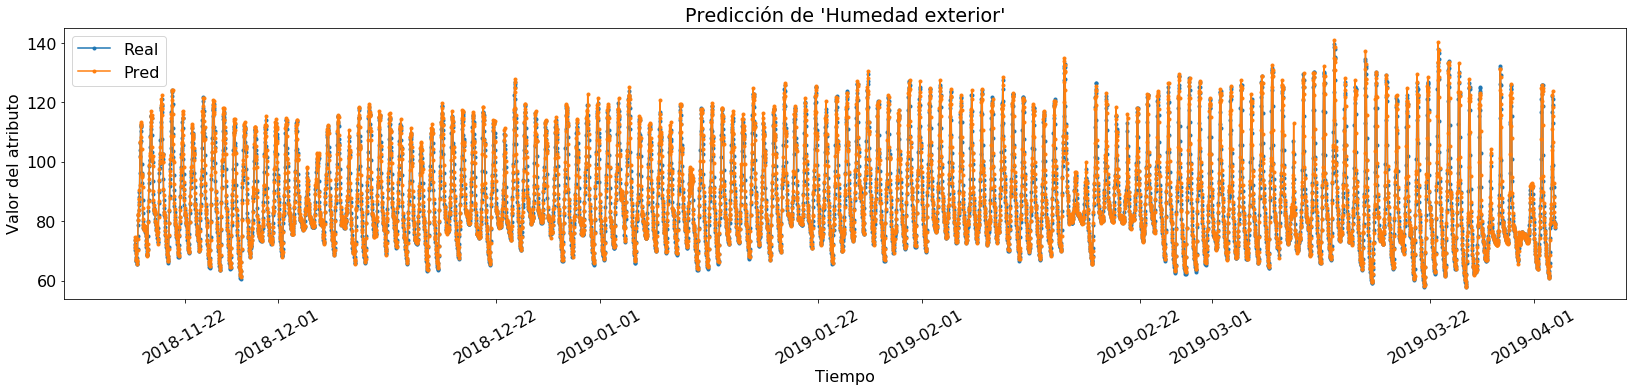

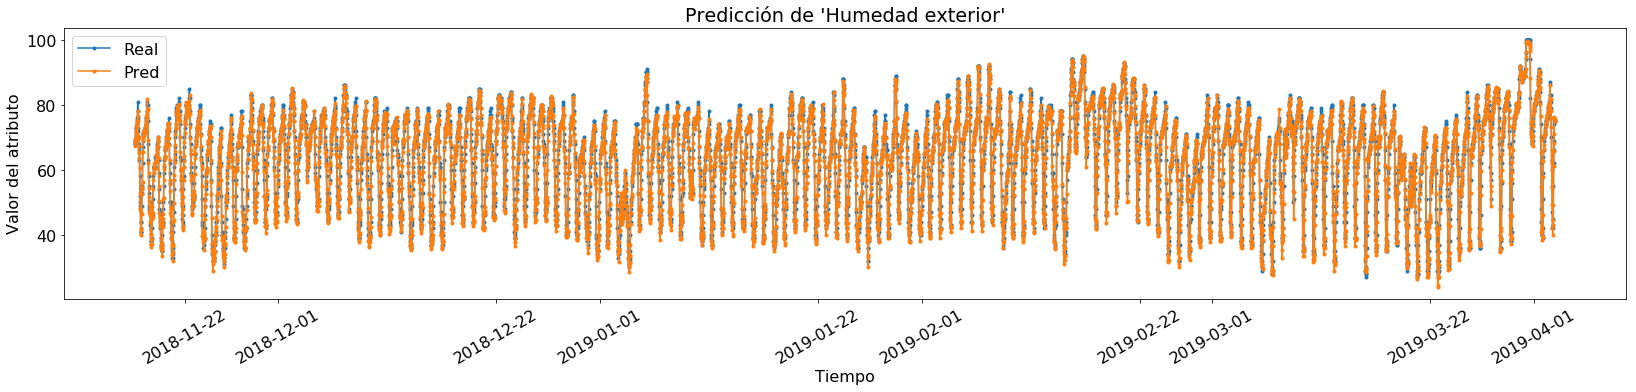

In [18]:
def chart_predictions(serie_df, column_target, scalers_dict, amount_of_lag, truth, pred):
    set_chart_font()
    plt.figure(figsize = (28,5))
    title_format="Predicción de '{}'"
    
    if column_target == 0:
        variable_name = "Temperatura interior"
        scaler = scalers_dict['temperatura_interior']
    elif column_target == 1:
        variable_name = "Humedad interior"
        scaler = scalers_dict['humedad_interior']
    elif column_target == 1:
        variable_name = "Temperatura exterior"
        scaler = scalers_dict['temperatura_exterior']
    else:
        variable_name= "Humedad exterior"
        scaler = scalers_dict['humedad_exterior']
        
    TRAIN_LENGTH = int(serie_df.shape[0] * TRAIN_PERCENTAGE)
    
    time = list(serie_df[TRAIN_LENGTH+amount_of_lag:].index)
    
    y_truth_transformed = np.expand_dims(truth[:,column_target], axis=1)
    y_truth_transformed = scaler.inverse_transform(y_truth_transformed)
    
    y_pred_transformed = np.expand_dims(pred[:,column_target], axis=1)
    y_pred_transformed = scaler.inverse_transform(y_pred_transformed)
    
    plt.plot(time, y_truth_transformed, '.-')
    plt.plot(time, y_pred_transformed, '.-')
    
    plt.xlabel('Tiempo')
    plt.ylabel('Valor del atributo')
    plt.legend( ('Real', 'Pred') )
    plt.title( title_format.format(variable_name) )
    plt.xticks(rotation=30)
    
    plt.show()
    
for i in range(4):
    chart_predictions(HASH_OF_TIME_SERIES[HOUSE_TO_TRAIN], i, scalers, EXAMPLE_AMOUNT_OF_LAG ,valitation_data[1], y_pred)

## Probando la red vs las otras casas

Ahora lo que se va a hacer se probar el desempeño de la red vs las otras casas

In [91]:
import sklearn.metrics as metrics
def predict_from_model(model, scalers, house_number):
    train_data, valitation_data = generate_matrix_from_scalers(HASH_OF_TIME_SERIES[house_number], scalers)
    
    y_pred = model.predict(valitation_data[0])
    
    mse = metrics.mean_squared_error(valitation_data[1], y_pred)
    mae = metrics.mean_absolute_error(valitation_data[1], y_pred)
    return (mse, mae)

def chart_from_model(model, scalers, serie_df):
    train_data, valitation_data = generate_matrix_from_scalers(serie_df, scalers)
    y_pred = model.predict(valitation_data[0])
    for i in range(4):
        chart_predictions(serie_df, i, scalers, valitation_data[1], y_pred)

In [31]:
HASH_OF_TIME_SERIES[273].shape

(7, 6)

In [64]:
house_performance = []
for i in HASH_OF_TIME_SERIES.keys():
    print(i)
    if HASH_OF_TIME_SERIES[i].shape[0] > 8000:
        house_performance.append( (i, *predict_from_model(model, scalers, i)) )
    
house_performance = sorted(house_performance, key=lambda x: x[2], reverse=True)

print(house_performance[0:5])

2
3
4
5
6
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


Se obtiene que la peor casa a predecir es la 296 (mean absolute error más alto). A continuación se adjunta el gráfico de la predicción.

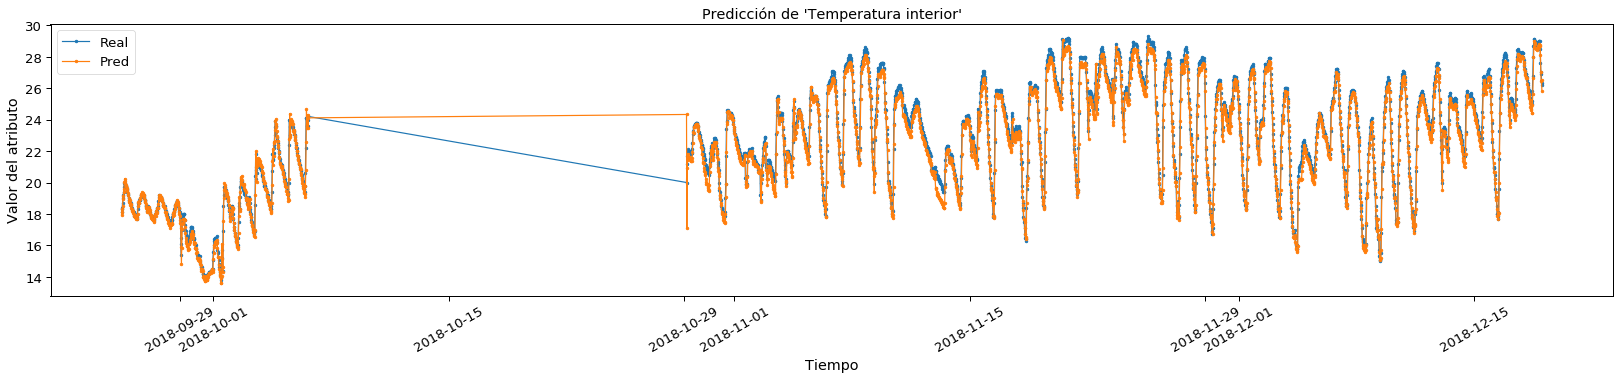

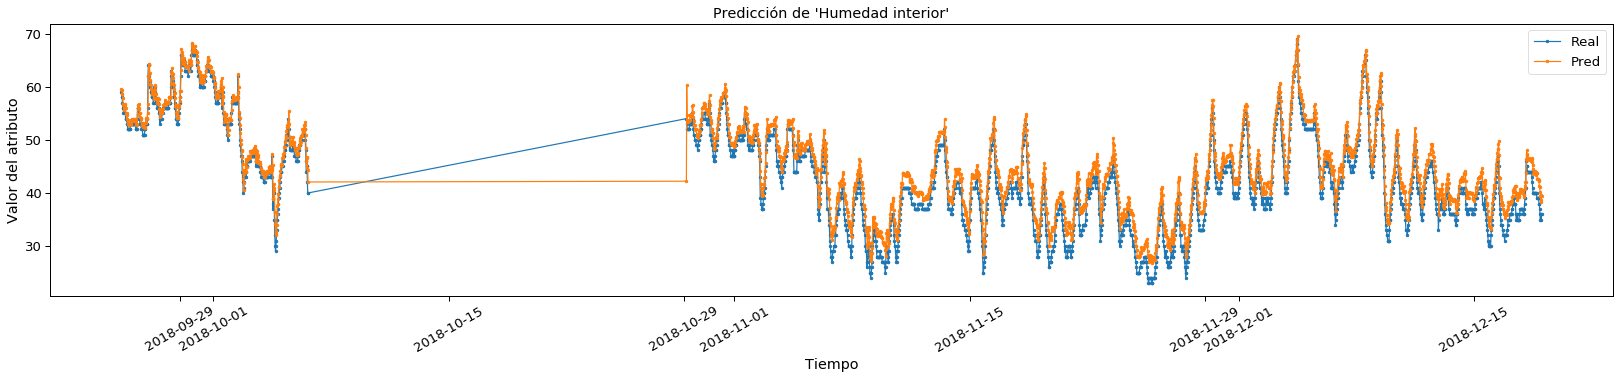

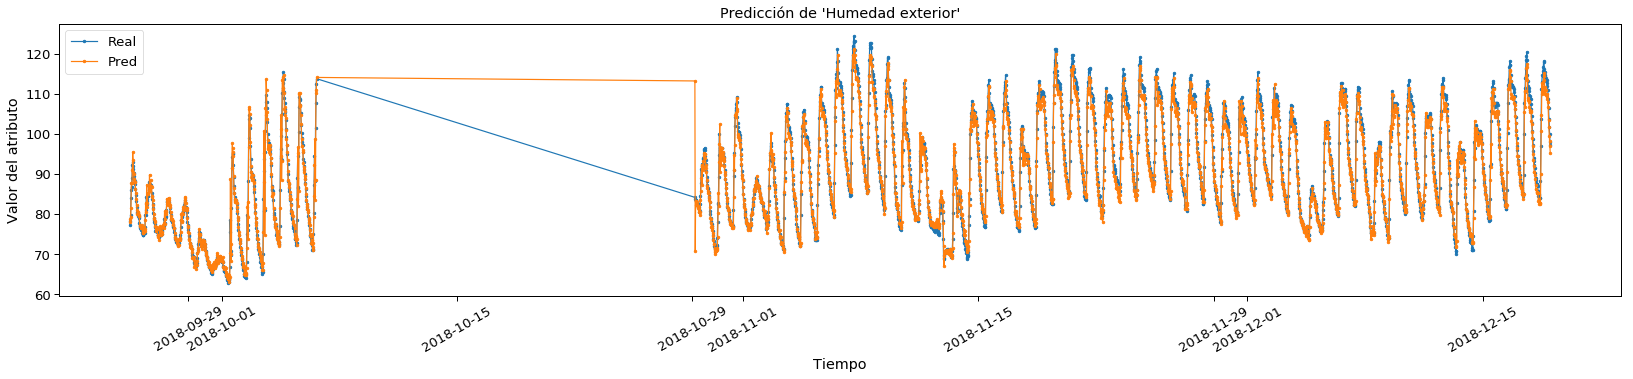

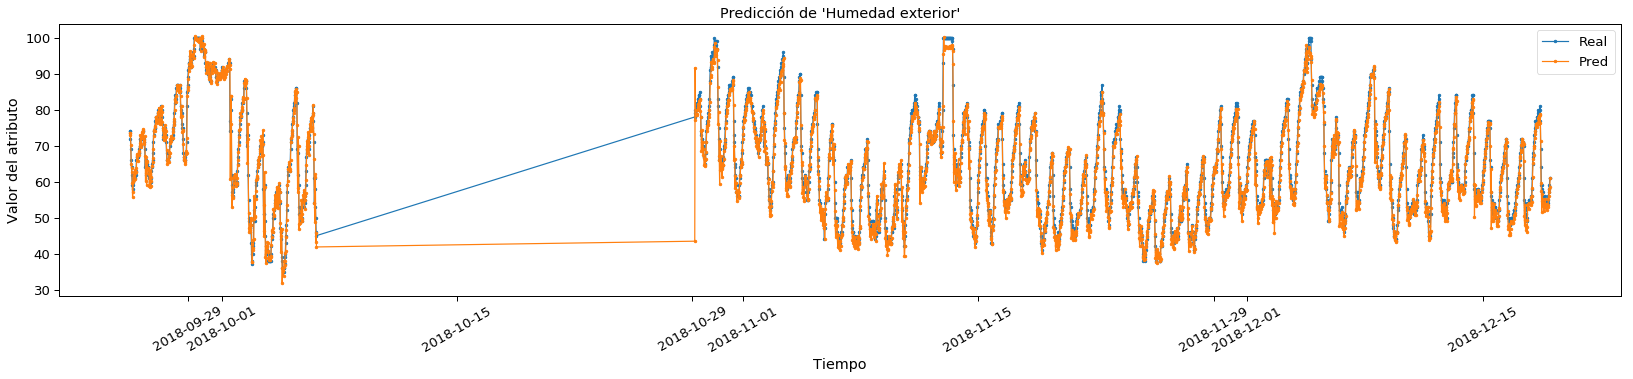

In [100]:
chart_from_model(model, scalers, HASH_OF_TIME_SERIES[296])

## ¿ Qué pasa en 1 hora más al futuro ?

La red entrenada anteriormente trabaja con mediciones que ocurren cada media hora, entonces sería interesante saber qué pasa cuando estas son cada 60 minutos para así poder predecir 60 minutos en el futuro.

Se procede a modificar las series de las casas 135 y 296 para que sean cada 60 minutos

In [95]:
def transform_to_hour(series_df):
    return series_df.copy().iloc[::2]

hour_serie_1 = transform_to_hour(HASH_OF_TIME_SERIES[HOUSE_TO_TRAIN])
hour_serie_2 = transform_to_hour(HASH_OF_TIME_SERIES[296])

In [96]:
model_2 = Sequential()

# Recurrente
model_2.add(CuDNNGRU(input_shape=(AMOUNT_OF_LAG, 4), units=100, return_sequences=False))

# FF
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(4))

model_2.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['mean_absolute_percentage_error'])  
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_5 (CuDNNGRU)       (None, 100)               31800     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 516       
Total params: 61,756
Trainable params: 61,756
Non-trainable params: 0
_________________________________________________________________


In [97]:
hour_train_data_1, hour_valitation_data_1, hour_scalers = generate_matrix(hour_serie_1)
print(hour_train_data_1[0].shape)
print(hour_valitation_data_1[0].shape)

hour_train_data_2, hour_valitation_data_2 = generate_matrix_from_scalers(hour_serie_2, hour_scalers)
print(hour_train_data_2[0].shape)
print(hour_valitation_data_2[0].shape)

(13123, 3, 4)
(3279, 3, 4)
(5954, 3, 4)
(1487, 3, 4)


In [98]:
history_2 = model_2.fit(hour_train_data_1[0], hour_train_data_1[1], validation_data=(hour_valitation_data_1[0], hour_valitation_data_1[1]), epochs=15, batch_size=256, verbose=1)

Train on 13123 samples, validate on 3279 samples
Epoch 1/15
13123/13123 [==============================] - 1s 71us/step - loss: 0.1430 - val_loss: 0.0578
Epoch 2/15
13123/13123 [==============================] - 0s 16us/step - loss: 0.0303 - val_loss: 0.0370
Epoch 3/15
13123/13123 [==============================] - 0s 15us/step - loss: 0.0230 - val_loss: 0.0284
Epoch 4/15
13123/13123 [==============================] - 0s 13us/step - loss: 0.0205 - val_loss: 0.0304
Epoch 5/15
13123/13123 [==============================] - 0s 14us/step - loss: 0.0197 - val_loss: 0.0235
Epoch 6/15
13123/13123 [==============================] - 0s 15us/step - loss: 0.0185 - val_loss: 0.0270
Epoch 7/15
13123/13123 [==============================] - 0s 14us/step - loss: 0.0179 - val_loss: 0.0229
Epoch 8/15
13123/13123 [==============================] - 0s 15us/step - loss: 0.0176 - val_loss: 0.0242
Epoch 9/15
13123/13123 [==============================] - 0s 14us/step - loss: 0.0175 - val_loss: 0.0219
Epoch 

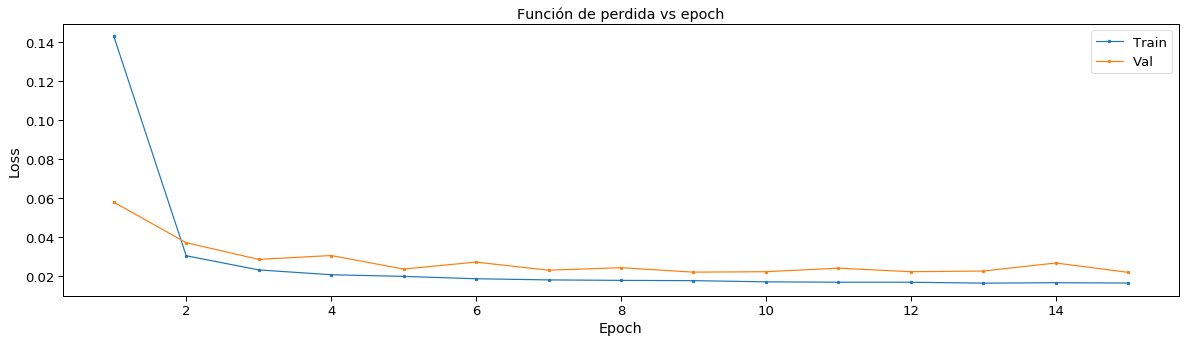

In [99]:
chart_loss(history_2, 15)

Una vez entrenada esta nueva red se procede a graficar la predicción

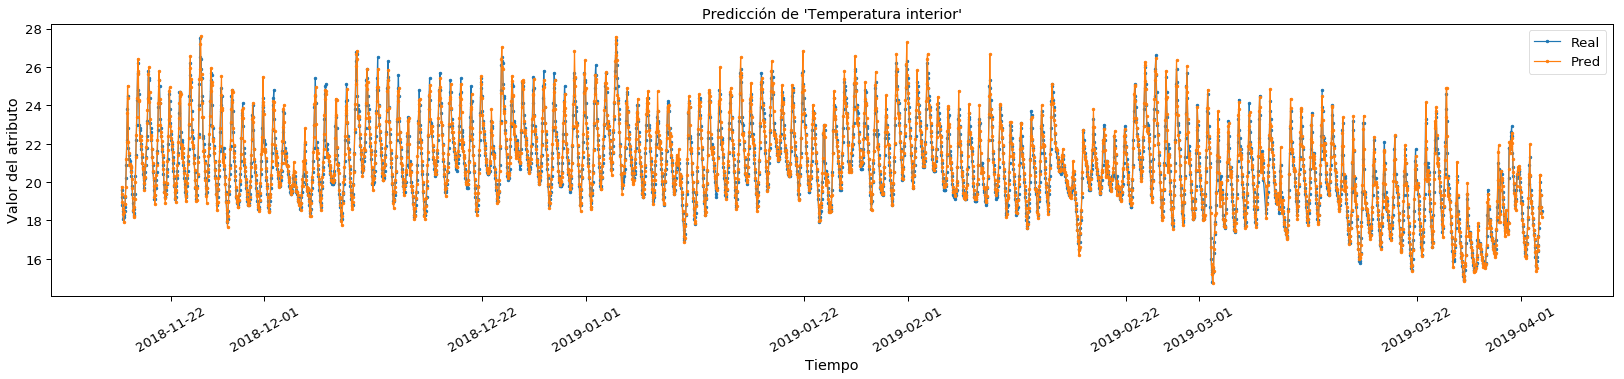

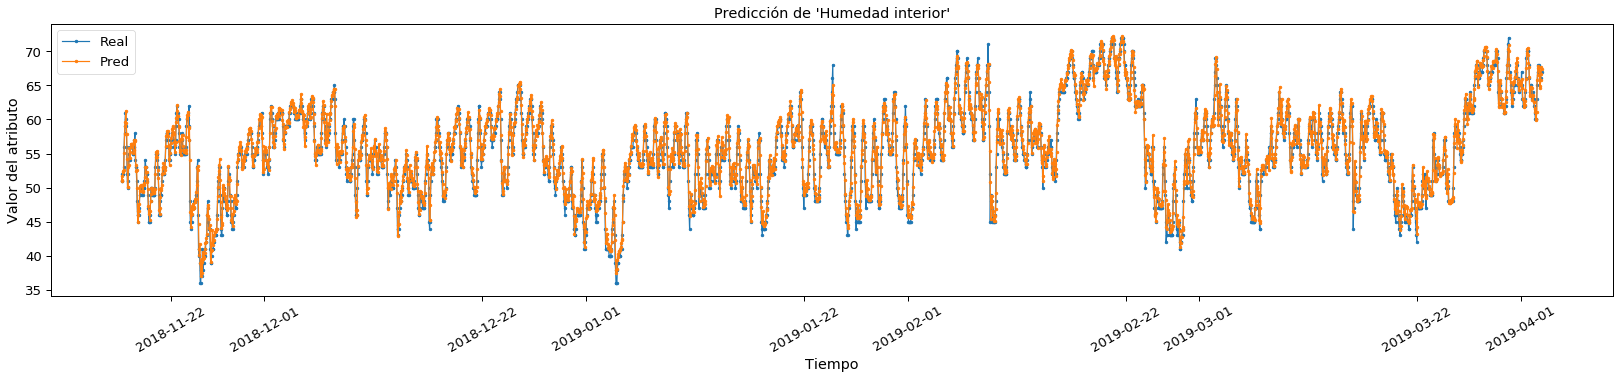

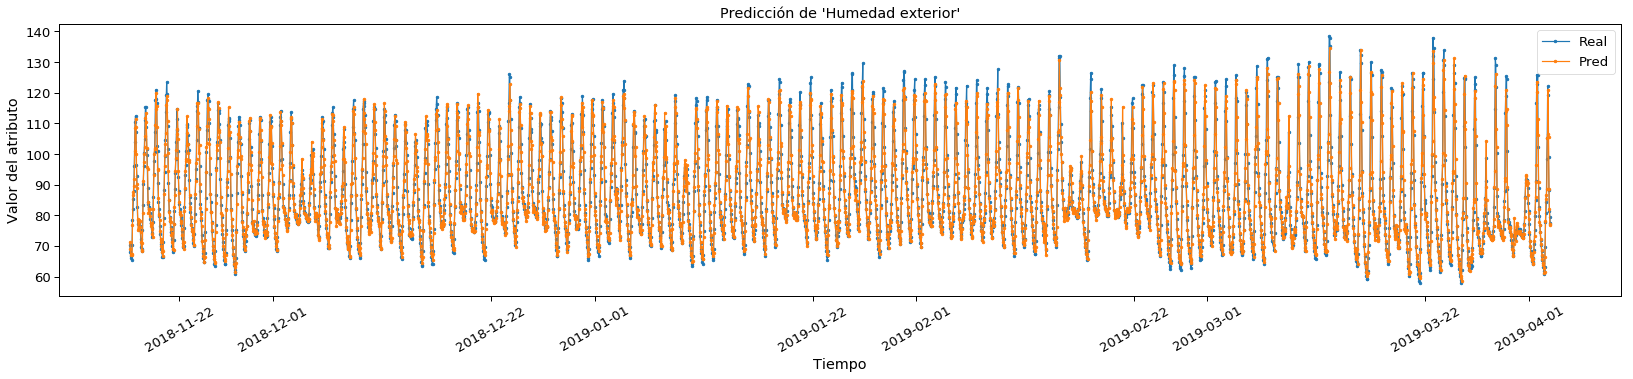

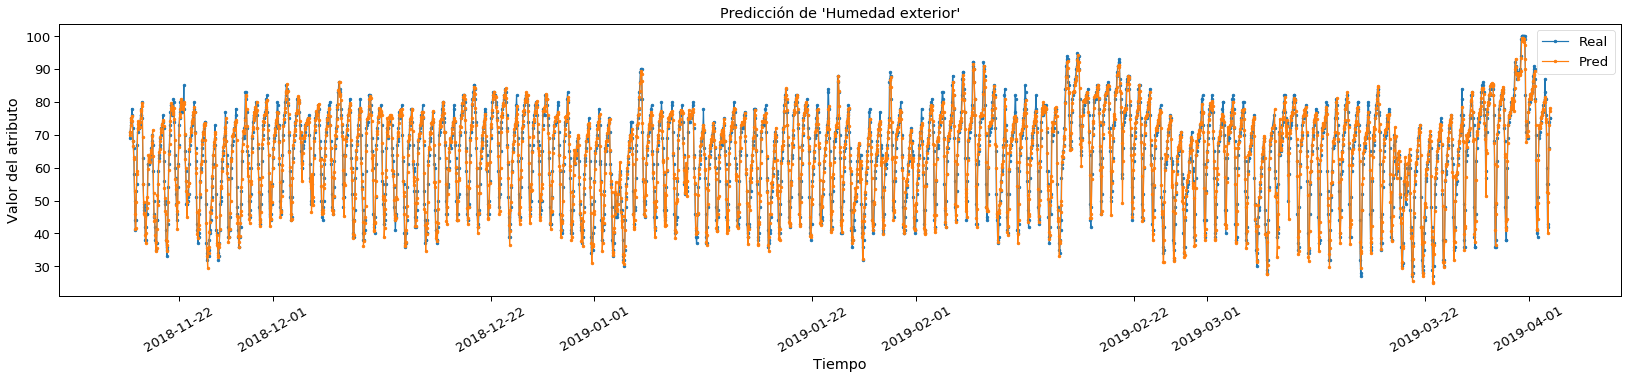

In [92]:
chart_from_model(model_2, hour_scalers, hour_serie_1)

Ahora se grafica la predicción sobre la casa 296, dicha casa era la peor predicha por el modelo en el caso de mediciones cada 30 minutos

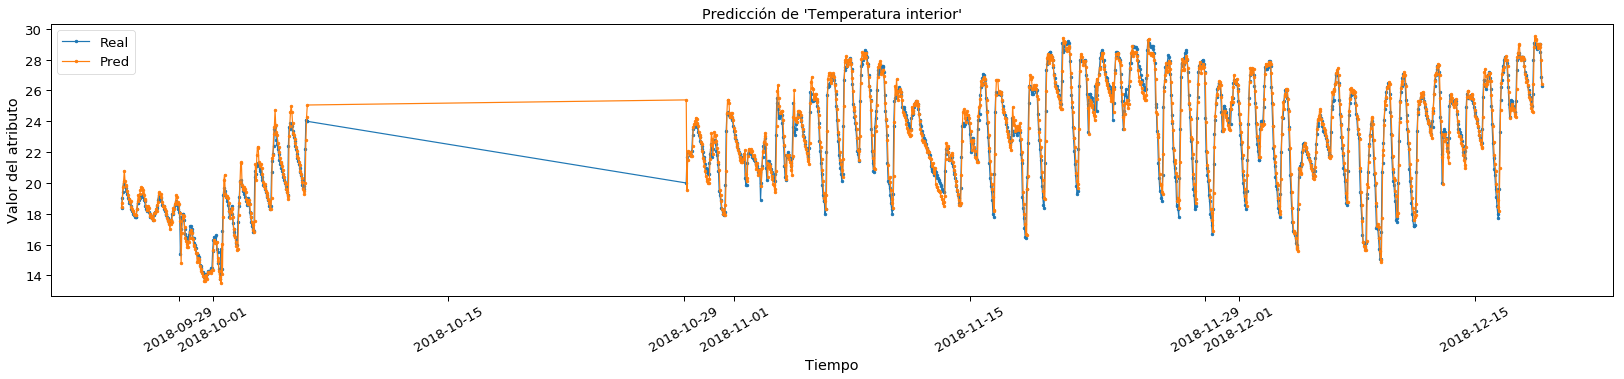

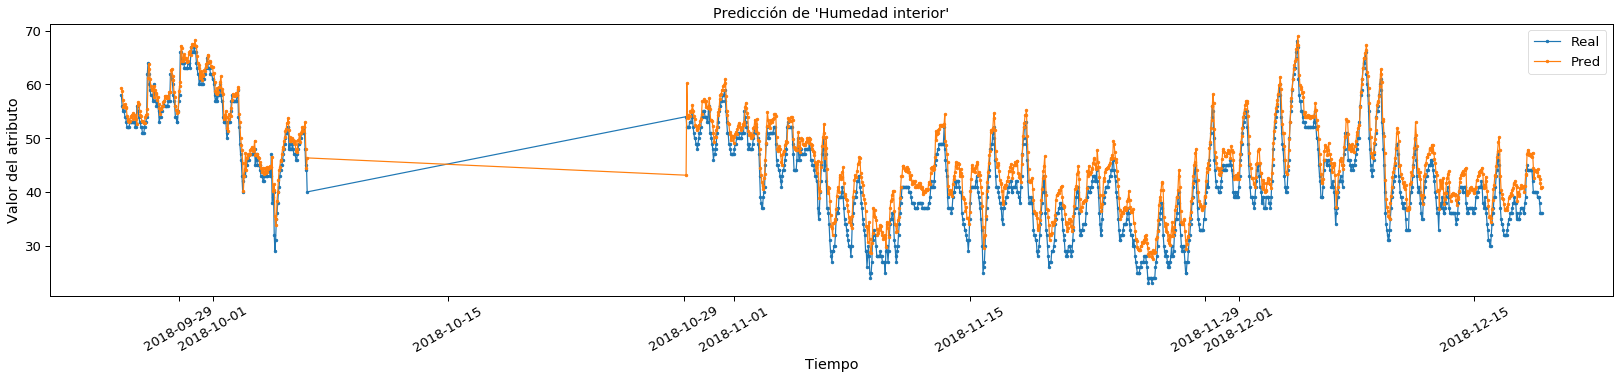

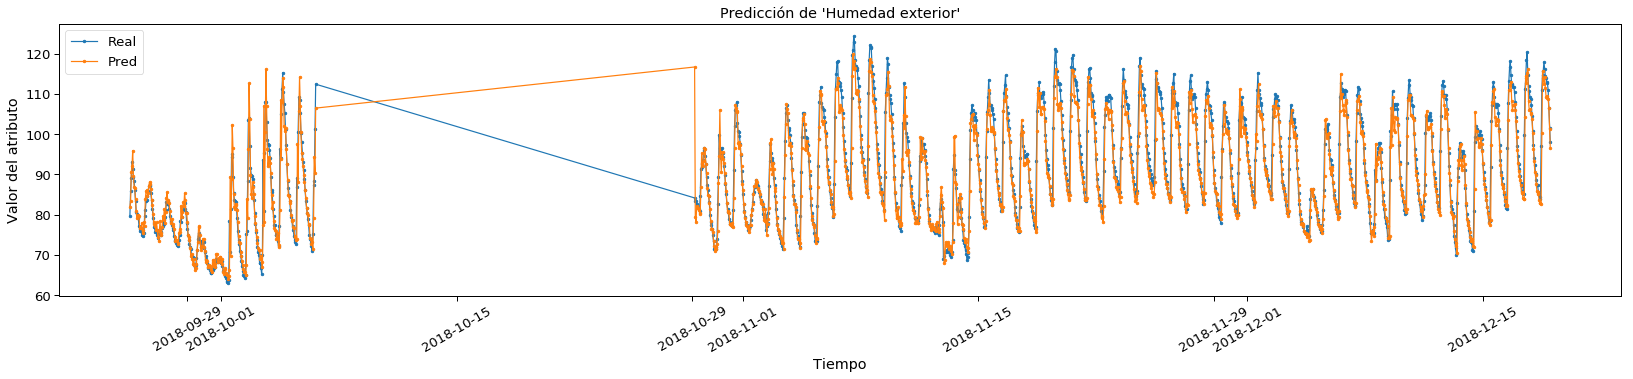

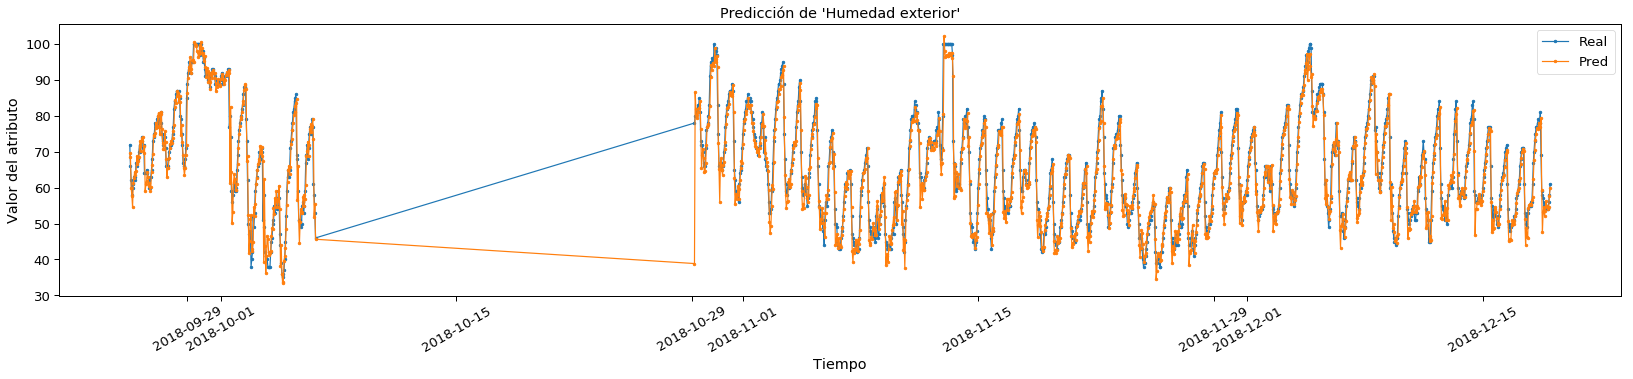

In [93]:
chart_from_model(model_2, hour_scalers, hour_serie_2)

## Haciendo pruebas

In [9]:
FEATURES_IN_STUDY = ["temperatura_interior", "humedad_interior", "temperatura_exterior", "humedad_exterior"]

In [5]:
def generate_network_A(number_of_examples):
    model = Sequential()

    # Recurrente
    model.add(CuDNNGRU(input_shape=(number_of_examples, 4), units=100, return_sequences=False))

    # FF
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    return model
    
def generate_network_B(number_of_examples):
    model = Sequential()

    # Recurrente
    model.add(CuDNNGRU(input_shape=(number_of_examples, 4), units=100, return_sequences=True))
    model.add(CuDNNGRU(input_shape=(number_of_examples, 4), units=100, return_sequences=False))

    # FF
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    return model
    
def generate_network_C(number_of_examples):
    model = Sequential()

    # Recurrente
    model.add(CuDNNGRU(input_shape=(number_of_examples, 4), units=100, return_sequences=True))
    model.add(CuDNNGRU(input_shape=(number_of_examples, 4), units=100, return_sequences=True))
    model.add(CuDNNGRU(input_shape=(number_of_examples, 4), units=100, return_sequences=False))

    # FF
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(4))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    return model

In [6]:
def divide_training_and_validation(array_of_houses, training_percentage):
    amount_of_houses = len(array_of_houses)
    train_lenght = int(amount_of_houses * training_percentage)
    training_houses = set(np.random.choice(array_of_houses, train_lenght, replace=False))
    validation_houses = set(array_of_houses) - set(training_houses)
    return (training_houses, validation_houses)

# Función que recibe una serie de pandas y retorna un robust scaler
def initialize_robust_scalers(series_df):
    scalers_dictionary = dict()
    
    # Se pone un RobustScaler por cada feature
    for i in FEATURES_IN_STUDY:
        scalers_dictionary[i] = RobustScaler()
    
    for column_name in FEATURES_IN_STUDY:
        # Se le hace fit al scaler
        scalers_dictionary[column_name].fit( np.expand_dims(series_df[column_name], axis=1))

    return scalers_dictionary

# Recibe una serie de pandas y un diccionario de RobustScalers. Aplica los scalers a la serie.
def standarize_serie(serie_df, scalers_dictionary):
    copy = serie_df.copy()
    for column_name in FEATURES_IN_STUDY:
        # Se transforma la data
        copy[column_name] = scalers_dictionary[column_name].transform(np.expand_dims(copy[column_name], axis=1))
        
    return copy

# Recibe una serie (standarizada) y retorna la matriz laggeada
def generate_lagged_matrix(serie_df, amoung_of_lag):
    X = list()
    Y = list()
    last_seen = list()
    
    for index, row in serie_df.iterrows():
        current_record = list()
        for i in FEATURES_IN_STUDY:
            current_record.append(row[i])
        if len(last_seen) < amoung_of_lag:
            last_seen.append(current_record)
        else:
            Y.append(list(current_record))
            X.append(list(last_seen))
            del last_seen[0]
            last_seen.append(current_record)
            
    return X, Y

In [18]:
from functools import reduce
def train_model(model, amount_of_lag, training_ids, general_df, hash_of_time_series):
    
    # Se proceden a inicializar los RobustScalers
    training_mask = general_df['vivienda_id'].map(lambda x: x in training_ids)
    scalers = initialize_robust_scalers(general_df[training_mask])
    
    # Se va a estandarizar todas las casas de entrenamiento con el RobustScaler y se va a generar
    # La matriz de lag correspondiente
    standarized_time_series = dict()
    X_train, Y_train = [], []
    # training_matrixs = dict()
    for i in training_ids:
        standarized_time_series[i] = standarize_serie(hash_of_time_series[i], scalers)
        x, y = generate_lagged_matrix(standarized_time_series[i], amount_of_lag)
        X_train.append(x)
        Y_train.append(y)
        
    X_train = np.asarray(reduce(lambda x,y: x+y, X_train))
    Y_train = np.asarray(reduce(lambda x,y: x+y, Y_train))
    
    history = model.fit(X_train, Y_train, epochs=10, batch_size=256, verbose=1)
    
    return scalers, history

In [12]:
model_A = generate_network_A(3)

# Training houses pool es una variable que tiene los ids de todas las casas cuya información faltante es menor a 10%
training_ids, validation_ids = divide_training_and_validation(training_houses_pool, 0.1)

model_A, scalers_A, history_A = train_model(model_A, 3, training_ids, df, HASH_OF_TIME_SERIES)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
180587/180587 [==============================] - 20s 108us/step - loss: 0.0112 - mean_absolute_error: 0.0551 - mean_absolute_percentage_error: 802422.9893
Epoch 2/10
180587/180587 [==============================] - 2s 11us/step - loss: 0.0030 - mean_absolute_error: 0.0323 - mean_absolute_percentage_error: 535281.8939
Epoch 3/10
180587/180587 [==============================] - 2s 11us/step - loss: 0.0028 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 525131.3757
Epoch 4/10
180587/180587 [==============================] - 2s 11us/step - loss: 0.0028 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 523419.6098
Epoch 5/10
180587/180587 [==============================] - 2s 11us/step - loss: 0.0027 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 521253.6309
Epoch 6/10
180587/180587 [==============================] - 2s 11us/step - loss: 0.0027 - mean_absolute_error: 0.0305 - mean_absol

In [13]:
history_A.history

{'loss': [0.011182342107877018,
  0.0030410720031119774,
  0.002838375381620901,
  0.002787497575968047,
  0.0027480650419676594,
  0.002717708022347075,
  0.002692534619192152,
  0.0026693369358661715,
  0.0026630049748603913,
  0.0026387836886369656],
 'mean_absolute_error': [0.055058681019234286,
  0.03227339144969724,
  0.030921274194706378,
  0.030798876464656212,
  0.030616204619175042,
  0.030514053922792796,
  0.03040323892195637,
  0.030296983349025194,
  0.0303627005821754,
  0.03015970256296392],
 'mean_absolute_percentage_error': [802422.9892607165,
  535281.8939250887,
  525131.3757433224,
  523419.60979783983,
  521253.63087165053,
  518132.95128352265,
  519356.80997247866,
  517677.1430798417,
  522489.6694822821,
  519342.5006824965]}

In [21]:
import math

# Recibe un iterable con los ids de validación y el hash de todas la series
# Retorna un has con las series. En cada entrada está la serie continua más larga
def clean_validation_data(validation_ids, hash_of_time_series):
    validation_series = {}
    for i in validation_ids:
        resampled_house = hash_of_time_series[i].resample('30min').mean()
        initial_date=""
        best_initial_date = ""
        best_end_date = ""
        longest_days = 0
        
        for index, row in resampled_house.iterrows():

            temperature = getattr(row, 'temperatura_interior')
            current_date = index
            
            # Si es que si veo algo de temperatura
            if not math.isnan(temperature):  
                if initial_date == "":
                    initial_date = current_date
                    
            else:
                if initial_date != "":
                    delta = last_date - initial_date
                    if delta.days > longest_days:
                        longest_days = delta.days
                        best_initial_date = initial_date
                        best_end_date = last_date
                    initial_date = ""
                
            last_date = current_date
            
        validation_series[i] = hash_of_time_series[i][best_initial_date:best_end_date]
        
    return validation_series

# Convierte una matriz (m x 4) a una de (m x 1) en donde el 1 es el feature seleccionado
# en la escala original c:
def return_feature_to_original_scale(matrix, scalers, feature):
    if feature == 0:
        scaler = scalers['temperatura_interior']
    elif feature == 1:
        scaler = scalers['humedad_interior']
    elif feature == 2:
        scaler = scalers['temperatura_exterior']
    else:
        scaler = scalers['humedad_exterior'] 
    
    transformed = np.expand_dims(matrix[:,feature], axis=1)
    return scaler.inverse_transform(transformed)

# Calcula las metricas dado el modelo y el hash de series de validacion
def calculate_metrics(model, scalers, amount_of_lag, validation_hash):
    
    # Calcula la media de una lista
    def calculate_mean(l):
        return sum(l)/len(l)

    in_temperature_mae = list()
    in_hum_mae = list()
    out_temperature_mae = list()
    out_hum_mae = list()
    
    in_temperature_mse = list()
    in_hum_mse = list()
    out_temperature_mse = list()
    out_hum_mse = list()
    
    for i in validation_hash:
        serie_df = validation_hash[i]
        standarized_serie = standarize_serie(serie_df, scalers)
        x, y = generate_lagged_matrix(standarized_serie, amount_of_lag)
        x, y = np.asarray(x), np.asarray(y)
        
        y_pred = model.predict(x)
        
        for j in range(4):
            y_pred_transformed = return_feature_to_original_scale(y_pred, scalers, j)
            y_transformed = return_feature_to_original_scale(y, scalers, j)

            mse = metrics.mean_squared_error(y_transformed, y_pred_transformed)
            mae = metrics.mean_absolute_error(y_transformed, y_pred_transformed)
            
            if j == 0:
                in_temperature_mae.append(mae)
                in_temperature_mse.append(mse)
            elif j == 1:
                in_hum_mae.append(mae)
                in_hum_mse.append(mse)
            elif j == 2:
                out_temperature_mae.append(mae)
                out_temperature_mse.append(mse)
            else:
                out_hum_mae.append(mae)
                out_hum_mse.append(mse)
        
    return ( (calculate_mean(in_temperature_mse), calculate_mean(in_temperature_mae)), (calculate_mean(in_hum_mse), calculate_mean(in_hum_mae)), (calculate_mean(out_temperature_mse), calculate_mean(out_temperature_mae)), (calculate_mean(out_hum_mse), calculate_mean(out_hum_mae)) )

In [16]:
validation_hash = clean_validation_data(validation_ids, HASH_OF_TIME_SERIES)
# validation_hash = clean_validation_data([2], HASH_OF_TIME_SERIES)

In [17]:
a = calculate_metrics(model_A, scalers_A, 3, validation_hash)
print(a)

((0.15367681131136443, 0.21606056364261852), (0.7660456813134694, 0.5796657646429365), (0.2401105564415168, 0.28698261522609764), (2.2169077192466413, 1.0142426442223462))


In [26]:
TRAINING_PERCENTAGES = [0.25, 0.5, 0.75]
LAGS = [2, 3, 4, 5]
# training_ids, validation_ids = divide_training_and_validation(training_houses_pool[:10], 0.3)

performance_hash = dict()

for t in TRAINING_PERCENTAGES:
    training_ids, validation_ids = divide_training_and_validation(training_houses_pool[:10], t)
    validation_hash = clean_validation_data(validation_ids, HASH_OF_TIME_SERIES)
    for l in LAGS:
        MODELS = [ ('A', generate_network_A(l)), ('B', generate_network_B(l)), ('C', generate_network_C(l))]
        for model_name, model in MODELS:
            scalers, history = train_model(model, l, training_ids, df, HASH_OF_TIME_SERIES)
            calculated_metrics = calculate_metrics(model, scalers, l, validation_hash)
            if model_name not in performance_hash:
                performance_hash[model_name] = []
            performance_hash[model_name].append((model, scalers, l, calculated_metrics))

Epoch 1/10
67970/67970 [==============================] - 2s 33us/step - loss: 0.0223 - mean_absolute_error: 0.0842 - mean_absolute_percentage_error: 1148705.4227
Epoch 2/10
67970/67970 [==============================] - 3s 50us/step - loss: 0.0038 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 682357.3783
Epoch 3/10
67970/67970 [==============================] - 3s 51us/step - loss: 0.0026 - mean_absolute_error: 0.0337 - mean_absolute_percentage_error: 548988.6864
Epoch 4/10
67970/67970 [==============================] - 4s 52us/step - loss: 0.0022 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 513895.4466
Epoch 5/10
67970/67970 [==============================] - 2s 27us/step - loss: 0.0020 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 501970.1807
Epoch 6/10
67970/67970 [==============================] - 1s 17us/step - loss: 0.0020 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 494073.1788
Epoch 7/10
67970/67970 [===

67968/67968 [==============================] - 7s 109us/step - loss: 0.0277 - mean_absolute_error: 0.1016 - mean_absolute_percentage_error: 1379535.9421
Epoch 2/10
67968/67968 [==============================] - 6s 87us/step - loss: 0.0041 - mean_absolute_error: 0.0435 - mean_absolute_percentage_error: 671644.7127
Epoch 3/10
67968/67968 [==============================] - 4s 54us/step - loss: 0.0027 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 573902.0828
Epoch 4/10
67968/67968 [==============================] - 3s 46us/step - loss: 0.0022 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 517487.5304
Epoch 5/10
67968/67968 [==============================] - 6s 87us/step - loss: 0.0021 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 512168.3326
Epoch 6/10
67968/67968 [==============================] - 7s 104us/step - loss: 0.0021 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 508581.5256
Epoch 7/10
67968/67968 [============

67964/67964 [==============================] - 4s 55us/step - loss: 0.0019 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 487860.8705
Epoch 1/10
67964/67964 [==============================] - 7s 110us/step - loss: 0.0199 - mean_absolute_error: 0.0824 - mean_absolute_percentage_error: 1119949.0405
Epoch 2/10
67964/67964 [==============================] - 4s 63us/step - loss: 0.0030 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 585592.1574
Epoch 3/10
67964/67964 [==============================] - 5s 73us/step - loss: 0.0023 - mean_absolute_error: 0.0318 - mean_absolute_percentage_error: 519541.4209
Epoch 4/10
67964/67964 [==============================] - 5s 73us/step - loss: 0.0021 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 504809.5621
Epoch 5/10
67964/67964 [==============================] - 5s 73us/step - loss: 0.0020 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 499819.2948
Epoch 6/10
67964/67964 [=============

102118/102118 [==============================] - 9s 89us/step - loss: 0.0028 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 723565.5048
Epoch 10/10
102118/102118 [==============================] - 9s 88us/step - loss: 0.0028 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 720569.4787
Epoch 1/10
102113/102113 [==============================] - 4s 40us/step - loss: 0.0182 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 1358727.8581
Epoch 2/10
102113/102113 [==============================] - 2s 21us/step - loss: 0.0033 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 778161.5892
Epoch 3/10
102113/102113 [==============================] - 2s 21us/step - loss: 0.0027 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 701600.8970
Epoch 4/10
102113/102113 [==============================] - 2s 20us/step - loss: 0.0027 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 696410.0740
Epoch 5/10
102113/102113 

102108/102108 [==============================] - 2s 20us/step - loss: 0.0026 - mean_absolute_error: 0.0332 - mean_absolute_percentage_error: 699840.1501
Epoch 9/10
102108/102108 [==============================] - 2s 20us/step - loss: 0.0026 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 703652.1779
Epoch 10/10
102108/102108 [==============================] - 2s 20us/step - loss: 0.0026 - mean_absolute_error: 0.0332 - mean_absolute_percentage_error: 705010.3870
Epoch 1/10
102108/102108 [==============================] - 5s 51us/step - loss: 0.0218 - mean_absolute_error: 0.0866 - mean_absolute_percentage_error: 1526810.6007
Epoch 2/10
102108/102108 [==============================] - 3s 26us/step - loss: 0.0036 - mean_absolute_error: 0.0402 - mean_absolute_percentage_error: 817603.5398
Epoch 3/10
102108/102108 [==============================] - 3s 25us/step - loss: 0.0029 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 742970.2099
Epoch 4/10
102108/102108 

163161/163161 [==============================] - 3s 16us/step - loss: 0.0023 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 515763.7885
Epoch 8/10
163161/163161 [==============================] - 3s 16us/step - loss: 0.0023 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 517498.3967
Epoch 9/10
163161/163161 [==============================] - 3s 16us/step - loss: 0.0023 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 514717.4738
Epoch 10/10
163161/163161 [==============================] - 3s 16us/step - loss: 0.0023 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 517363.9552
Epoch 1/10
163161/163161 [==============================] - 6s 39us/step - loss: 0.0133 - mean_absolute_error: 0.0624 - mean_absolute_percentage_error: 895921.1226
Epoch 2/10
163161/163161 [==============================] - 3s 20us/step - loss: 0.0027 - mean_absolute_error: 0.0335 - mean_absolute_percentage_error: 556972.9726
Epoch 3/10
163161/163161 [

Epoch 7/10
163154/163154 [==============================] - 4s 26us/step - loss: 0.0024 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 535812.8841
Epoch 8/10
163154/163154 [==============================] - 4s 26us/step - loss: 0.0024 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 531019.5119
Epoch 9/10
163154/163154 [==============================] - 4s 26us/step - loss: 0.0024 - mean_absolute_error: 0.0319 - mean_absolute_percentage_error: 538614.6743
Epoch 10/10
163154/163154 [==============================] - 4s 26us/step - loss: 0.0024 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 528517.7025
Epoch 1/10
163147/163147 [==============================] - 6s 39us/step - loss: 0.0118 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 864716.5818
Epoch 2/10
163147/163147 [==============================] - 3s 17us/step - loss: 0.0025 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 529745.8282
Epoch 3/10
1631

163140/163140 [==============================] - 4s 24us/step - loss: 0.0023 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 525077.7638
Epoch 7/10
163140/163140 [==============================] - 4s 25us/step - loss: 0.0023 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 522122.2321
Epoch 8/10
163140/163140 [==============================] - 4s 24us/step - loss: 0.0023 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 523980.6125
Epoch 9/10
163140/163140 [==============================] - 4s 24us/step - loss: 0.0023 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 520027.4959
Epoch 10/10
163140/163140 [==============================] - 4s 24us/step - loss: 0.0023 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 521981.7352
Epoch 1/10
163140/163140 [==============================] - 9s 58us/step - loss: 0.0134 - mean_absolute_error: 0.0647 - mean_absolute_percentage_error: 939787.1774
Epoch 2/10
163140/163140 [

In [31]:
for i in performance_hash:
    for j in performance_hash[i]:
        print (i, j[2], j[3])

A 2 ((0.04984265938124546, 0.14075702988323474), (1.1078338530017913, 0.695777155841187), (0.2794097649137127, 0.2730882027768133), (2.1898529776861198, 0.9736523495635431))
A 3 ((0.05089254907555418, 0.14294414975105263), (1.1256691398317553, 0.7251961406987164), (0.2771424709954319, 0.2662977912333517), (2.25521740616983, 0.9942403343449269))
A 4 ((0.05315379534992449, 0.142115479735368), (1.0522501740720283, 0.6962933019484758), (0.2711920659232033, 0.2568863905561508), (2.19685186915406, 0.9806594568258384))
A 5 ((0.049184333520279205, 0.13992627392288767), (1.1563458225715215, 0.7349164388188641), (0.28236365795231283, 0.2704593453031304), (2.1716458688382656, 0.9761414719242456))
A 2 ((0.06200293653460202, 0.15314824077449873), (1.14427994343592, 0.7162630083679996), (0.11912255047718681, 0.24525244902819124), (1.5822876411017384, 0.8357478551182762))
A 3 ((0.05713643833216505, 0.1499076328222122), (1.0951242128639405, 0.6875147862930195), (0.11288610632857357, 0.2285113540498834

In [ ]:
def chart_loss(history, epoch_number):
    set_chart_font()
    epoch_arr = [i+1 for i in range(epoch_number)]
    plt.figure(figsize = (20,5))
    plt.plot(epoch_arr, history.history['loss'], '.-')
    plt.plot(epoch_arr, history.history['mean_absolute_error'], '.-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend( ('Train', 'Val', 'MAE') )
    plt.title("Función de perdida vs epoch")

    # min_index = np.argmin(history.history['val_loss'])
    # min_value = history.history['val_mean_absolute_percentage_error'][min_index].round(3)
    # plt.annotate('Min = {}'.format(min_value), xy=(min_index+1, min_value), xycoords='data', xytext=(-100, 100), textcoords='offset points', fontsize=14, arrowprops=dict(arrowstyle="->"))


    plt.show()

## Caracterización casas

In [ ]:
df_casas = pd.read_csv("./datasets/RENAM_encuesta_inicial.csv")

In [ ]:
# Se pasa el vivienda_id
def clean_id( x ):
    return int(x[2:])
   
df_casas['vivienda_id'] = np.vectorize(clean_id)(df_casas['ID'])

In [ ]:
print(df_casas.shape)
df_casas.head(3)

Voy a armar varios grupos con caracterizaciones tipo para ver de que tamaño quedan los grupos

In [ ]:
print("- Ciudades")
display(df_casas.groupby(['Ciudad']).count()[['vivienda_id']])

print("- Año de contrucción")
display(df_casas.groupby(['Año de construcción de la vivienda']).count()[['vivienda_id']])

# print("- Personas en la casa")
# display(df_casas.groupby(['N° de personas que componen el hogar (incluyendo el encuestado)']).count()[['vivienda_id']])

print("- Origen de la vivienda")
display(df_casas.groupby(['¿Cuál es el origen de su vivienda?']).count()[['vivienda_id']])

print("- Ciudad + Año de contrucción")
display(df_casas.groupby(['Año de construcción de la vivienda', 'Ciudad', '¿Cuál es el origen de su vivienda?']).count()[['vivienda_id']])

In [ ]:
i = 0
for x in df_casas.columns:
    print("{}, {}".format(i, x))
    i+=1

In [ ]:
relevant = [0, 2, 3, 4, 5, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 31, 32, 52, 53, 54, 66, 67, 73, 74, 75, 76]

# Ahora en la segunda 'iteración'
relevant2 = []

# Datos que me quedaron con duda 25 al 30

df_relevant = df_casas.iloc[:, relevant]

In [ ]:
for x in df_relevant.columns:
    uniq = df_relevant[x].unique()
    print("=== {}: {} ===".format(x, len(uniq)))
    print(uniq)

In [ ]:
display(df_relevant.isnull().sum())

## Anexo: Importar dataset a bd en postgres

In [ ]:
# Código que importa el csv a postgres
import psycopg2

def export_to_db():
    try:
        connection = psycopg2.connect(user = "postgres",
                                      password = "abc123",
                                      host = "127.0.0.1",
                                      port = "5432",
                                      database = "memoria")
        cursor = connection.cursor()

        insert_rows_format = '''
        insert into mediciones_netatmo
        (dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)
        values ({}, {}, {}, {}, {}, {}, {}, {}, '{}'),
        '''
        row_format = "({}, {}, {}, {}, {}, {}, {}, {}, '{}')"
        i = 0
        for row in df.itertuples(index=True, name='Pandas'):
            # print getattr(row, "c1"), getattr(row, "c2")

            sector = False

            dispositivo_id = getattr(row, 'dispositivo_id')
            vivienda_id = getattr(row, 'vivienda_id')

            if getattr(row, 'sector') == 1:
                sector = True

            temperatura = getattr(row, 'temperatura')
            humedad = getattr(row, 'humedad')
            co2 = getattr(row, 'co2')
            ruido = getattr(row, 'ruido')
            measured_at = getattr(row, 'measured_at')
            date_measured_at = pd.to_datetime(measured_at, unit='s')

            if i == 0:
                SQL = insert_rows_format.format(dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)
            elif i < 20000:
                SQL+= row_format.format(dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)+","
            else:
                SQL+= row_format.format(dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)
                SQL = SQL.replace("nan", "NULL")
                cursor.execute(SQL)
                connection.commit()
                SQL = ""
                i = -1
            i+=1

        if SQL != "":
            SQL+= row_format.format(dispositivo_id, vivienda_id, sector, temperatura, humedad, co2, ruido, measured_at, date_measured_at)
            SQL = SQL.replace("nan", "NULL")
            cursor.execute(SQL)
            connection.commit()

    except (Exception, psycopg2.Error) as error :
        print ("Error while connecting to PostgreSQL", error)
    finally:
        #closing database connection.
            if(connection):
                cursor.close()
                connection.close()
                print("PostgreSQL connection is closed")
                
# export_to_db()